In [1]:
# mounting the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers
!git clone https://github.com/aub-mind/arabert
!pip install torch
import transformers
from transformers import AutoTokenizer, AutoModel
import torch
import os
import re
import nltk
import pickle
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
import string
import random
from collections import deque
from collections import defaultdict
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.9 MB/s eta 0:00:00
Cloning into 'arabert'...
remote: Enumerating objects: 600, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 600 (delta 38), reused 45 (delta 30), pack-reused 535
Receiving objects: 100% (600/600), 9.14 MiB | 33.43 MiB/s, done.
Resolving deltas: 100% (339/339), done.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# loading all files into corpus1 text file
corpus_directory = "/content/drive/My Drive/OpenITI/T1_processed_arabertv2_lines"
corpus_files1 = []
max_file_size = 4 * 1024 * 1024 * 1024  # 4 GB

queue = deque([corpus_directory])

total_size = 0
while queue:
    current_directory = queue.popleft()
    for file_name in os.listdir(current_directory):
        file_path = os.path.join(current_directory, file_name)
        if os.path.isdir(file_path):
            queue.append(file_path)
        elif not file_name.startswith('.') and not file_name.endswith(('.yml', '.md')):
            file_size = os.path.getsize(file_path)
            if total_size + file_size <= max_file_size:
                corpus_files1.append(file_path)
                total_size += file_size

random.shuffle(corpus_files1)

with open("corpus1.txt", "w", encoding='utf-8') as outfile:
    for file_path in corpus_files1:
        with open(file_path, "r", encoding='utf-8') as infile:
            for line in infile:
                outfile.write(line)
            outfile.write("\n")  # Add a newline character between files

In [4]:
# loading all files into corpus2 text file
corpus_directory = "/content/drive/My Drive/OpenITI/T2_processed_arabertv2_lines"
corpus_files2 = []
max_file_size = 4 * 1024 * 1024 * 1024  # 4 GB

queue = deque([corpus_directory])

total_size = 0
while queue:
    current_directory = queue.popleft()
    for file_name in os.listdir(current_directory):
        file_path = os.path.join(current_directory, file_name)
        if os.path.isdir(file_path):
            queue.append(file_path)
        elif not file_name.startswith('.') and not file_name.endswith(('.yml', '.md')):
            file_size = os.path.getsize(file_path)
            if total_size + file_size <= max_file_size:
                corpus_files2.append(file_path)
                total_size += file_size

random.shuffle(corpus_files2)

with open("corpus2.txt", "w", encoding='utf-8') as outfile:
    for file_path in corpus_files2:
        with open(file_path, "r", encoding='utf-8') as infile:
            for line in infile:
                outfile.write(line)
            outfile.write("\n")  # Add a newline character between files

In [ ]:
# creating frequency of vocabulary for each corpus
corpus1_file = "corpus1.txt"
stop_words = set(stopwords.words("arabic"))  # loading stopwords
chunk_size = 100000

freq_dist1 = defaultdict(int)

with open(corpus1_file, "r", encoding="utf-8") as file:
    while True:
        chunk = file.read(chunk_size)
        if not chunk:
            break
        for word in chunk.split():
            if word not in stop_words: # Remove stopwords
                freq_dist1[word] += 1

freq_dist1_file = "corpus1_freq_dist.pkl"
with open(freq_dist1_file, "wb") as file:
    pickle.dump(freq_dist1, file)

corpus2_file = "corpus2.txt"
stop_words = set(stopwords.words("arabic"))  # loading stopwords
chunk_size = 100000

freq_dist2 = defaultdict(int)

with open(corpus2_file, "r", encoding="utf-8") as file:
    while True:
        chunk = file.read(chunk_size)
        if not chunk:
            break
        for word in chunk.split():
            if word not in stop_words: # Remove stopwords
                freq_dist2[word] += 1

freq_dist2_file = "corpus2_freq_dist.pkl"
with open(freq_dist2_file, "wb") as file:
    pickle.dump(freq_dist2, file)

In [ ]:
with open("corpus1_freq_dist.pkl", "rb") as file:
    freq_dist1 = pickle.load(file)

with open("corpus2_freq_dist.pkl", "rb") as file:
    freq_dist2 = pickle.load(file)

# Combine the frequency distributions
from collections import defaultdict
combined_freq_dist = defaultdict(int)
combined_freq_dist.update(freq_dist1)
combined_freq_dist.update(freq_dist2)

# Extract the keys (words) from the frequency distribution
vocabulary = list(combined_freq_dist.keys())

# Calculate the number of words in the vocabulary
num_words = len(vocabulary)

print("Number of words in the vocabulary:", num_words)

Number of words in the vocabulary: 1327911


In [ ]:
# Load the frequency distributions from pickle files
with open("corpus1_freq_dist.pkl", "rb") as file:
    freq_dist1 = pickle.load(file)

with open("corpus2_freq_dist.pkl", "rb") as file:
    freq_dist2 = pickle.load(file)

# Remove punctuation marks
translator = str.maketrans("", "", string.punctuation)
freq_dist1_cleaned = {word.translate(translator): freq_dist1[word] for word in freq_dist1}
freq_dist2_cleaned = {word.translate(translator): freq_dist2[word] for word in freq_dist2}

# Get the common words between the two frequency distributions
target_words = set(freq_dist1_cleaned).intersection(freq_dist2_cleaned)

# Filter out words with frequency greater than 300,000, punctuation marks, numbers, non-Arabic characters, and single/double-character words
filtered_target_words = [
    word for word in target_words
    if (
        freq_dist1_cleaned.get(word, 0) + freq_dist2_cleaned.get(word, 0) > 0
        and freq_dist1_cleaned.get(word, 0) + freq_dist2_cleaned.get(word, 0) <= 300000
        and not bool(re.search(r'[A-Za-z]', word))  # Exclude English characters
        and bool(re.search(r'^[ء-ي]+$', word))  # Include only Arabic characters
        and not len(word) == 1  # Exclude single-character words
        and not len(word) == 2 # Exclude double-character words
        and word not in ["؟", ">>", "<<"]  # Exclude specific characters
        and not word.startswith("ال")  # Exclude words starting with "ال"
    )
]

# Sort the target words by frequency and select the top 100
target_words = sorted(
    filtered_target_words,
    key=lambda word: -freq_dist1_cleaned[word] - freq_dist2_cleaned[word])[:300]

# Adding custom words to the target words set
custom_words = ["طائر", "شاش", "موقع", "حائط", "سيار", "طيار", "الله"]
target_words.extend(custom_words)
# Save the top_target_words as a pickle file
with open("target_words.pkl", "wb") as file:
    pickle.dump(target_words, file)

# Create a DataFrame for target words and their frequencies
data = {"Target Word": [], "C1 Frequency": [], "C2 Frequency": []}

# Add target words to the DataFrame
for word in target_words:
    data["Target Word"].append(word)
    data["C1 Frequency"].append(freq_dist1_cleaned.get(word, 0))
    data["C2 Frequency"].append(freq_dist2_cleaned.get(word, 0))

# Create the DataFrame
df = pd.DataFrame(data)

# Print the DataFrame
print(df)

    Target Word  C1 Frequency  C2 Frequency
0          خالد        217766         82220
1           رفع        147955        151737
2          يعلم        117406        182184
3           قلب        136899        160537
4           كفر        108660        187331
..          ...           ...           ...
302        موقع          9545         22076
303        حائط         16470         14535
304        سيار         15911         15666
305        طيار          1864          2934
306        الله       6347873       5609848

[307 rows x 3 columns]


In [ ]:
# Calculate the total frequency for each target word
df["Total Frequency"] = df["C1 Frequency"] + df["C2 Frequency"]

# Sort the DataFrame in ascending order based on the "Total Frequency" column
df_sorted = df.sort_values(by="Total Frequency", ascending=True)

# Print the sorted DataFrame
print(df_sorted)

    Target Word  C1 Frequency  C2 Frequency  Total Frequency
301         شاش          1900          1212             3112
305        طيار          1864          2934             4798
300        طائر         13341         13640            26981
303        حائط         16470         14535            31005
304        سيار         15911         15666            31577
..          ...           ...           ...              ...
3           قلب        136899        160537           297436
2          يعلم        117406        182184           299590
1           رفع        147955        151737           299692
0          خالد        217766         82220           299986
306        الله       6347873       5609848         11957721

[307 rows x 4 columns]


In [5]:
# loading target words into memory
file_path = 'target_words.pkl'

# Open the Pickle file and load the data
with open(file_path, 'rb') as file:
    target_words = pickle.load(file)

In [6]:
# getting sentences with target words
def write_target_word_occurrences(target_words, corpus_file, output_file, num_occurrences=5000):
    with open(corpus_file, 'r') as infile, open(output_file, 'w') as outfile:
        for target_word in target_words:
            outfile.write(f"Occurrences for '{target_word}':\n")
            occurrences_count = 0

            # Reset the file pointer to the beginning of the file
            infile.seek(0)

            for line in infile:
                line = line.strip()

                if target_word in line:
                    outfile.write(line + '\n')
                    occurrences_count += 1

                    if occurrences_count == num_occurrences:
                        break

            outfile.write('\n')

if __name__ == "__main__":
    num_occurrences = 5000

    # Corpus 1
    corpus_file1 = "corpus1.txt"
    output_file1 = "corpus1_occurrences.txt"
    write_target_word_occurrences(target_words, corpus_file1, output_file1, num_occurrences)

    # Corpus 2
    corpus_file2 = "corpus2.txt"
    output_file2 = "corpus2_occurrences.txt"
    write_target_word_occurrences(target_words, corpus_file2, output_file2, num_occurrences)


In [10]:
def compute_tokens_per_target(occurrences_file):
    tokens_per_target = {}

    with open(occurrences_file, 'r') as infile:
        lines = infile.readlines()

    target_word = None

    for line in lines:
        line = line.strip()

        if line.startswith("Occurrences for"):
            target_word = line.split("'")[1]
            tokens_per_target[target_word] = 0
        elif target_word is not None and line:
            tokens_per_target[target_word] += len(line.split())

    return tokens_per_target

if __name__ == "__main__":
    corpus1_occurrences_file = "corpus1_occurrences.txt"
    corpus2_occurrences_file = "corpus2_occurrences.txt"

    # Calculate tokens per target for each corpus
    corpus1_tokens_per_target = compute_tokens_per_target(corpus1_occurrences_file)
    corpus2_tokens_per_target = compute_tokens_per_target(corpus2_occurrences_file)

    print("Tokens per target word in Corpus 1:")
    for target_word, tokens in corpus1_tokens_per_target.items():
        print(f"Target Word: {target_word}, Tokens: {tokens}")

    print("\nTokens per target word in Corpus 2:")
    for target_word, tokens in corpus2_tokens_per_target.items():
        print(f"Target Word: {target_word}, Tokens: {tokens}")



Tokens per target word in Corpus 1:
Target Word: خالد, Tokens: 109083
Target Word: رفع, Tokens: 130836
Target Word: يعلم, Tokens: 121556
Target Word: قلب, Tokens: 123515
Target Word: كفر, Tokens: 122892
Target Word: نصر, Tokens: 99340
Target Word: إنسان, Tokens: 122079
Target Word: عزيز, Tokens: 106477
Target Word: أراد, Tokens: 128030
Target Word: أيام, Tokens: 121123
Target Word: دليل, Tokens: 122542
Target Word: طلب, Tokens: 122951
Target Word: أخرى, Tokens: 125159
Target Word: إيمان, Tokens: 121199
Target Word: شعر, Tokens: 109838
Target Word: نسخ, Tokens: 125984
Target Word: بغداد, Tokens: 84101
Target Word: مسجد, Tokens: 121200
Target Word: ربيع, Tokens: 98068
Target Word: يجب, Tokens: 124644
Target Word: حرم, Tokens: 113723
Target Word: سفيان, Tokens: 110495
Target Word: علماء, Tokens: 119569
Target Word: حجر, Tokens: 124096
Target Word: بقي, Tokens: 122400
Target Word: كسر, Tokens: 137252
Target Word: إسناد, Tokens: 121198
Target Word: سأل, Tokens: 124435
Target Word: جواب, Tok

In [ ]:
def calculate_average_line_length(file_path):
    total_words = 0
    total_lines = 0

    with open(file_path, 'r') as infile:
        for line in infile:
            words = line.strip().split()
            total_words += len(words)
            total_lines += 1

    if total_lines == 0:
        return 0  # To avoid division by zero if the file is empty

    average_length = total_words / total_lines
    return average_length

if __name__ == "__main__":
    file_path = "corpus1_occurrences.txt"

    avg_line_length = calculate_average_line_length(file_path)
    print(f"The average line length in '{file_path}' is: {avg_line_length:.2f} words")


The average line length in 'corpus1_occurrences.txt' is: 24.75 words


In [ ]:
def calculate_average_line_length(file_path):
    total_words = 0
    total_lines = 0

    with open(file_path, 'r') as infile:
        for line in infile:
            words = line.strip().split()
            total_words += len(words)
            total_lines += 1

    if total_lines == 0:
        return 0  # To avoid division by zero if the file is empty

    average_length = total_words / total_lines
    return average_length

if __name__ == "__main__":
    file_path = "corpus2_occurrences.txt"

    avg_line_length = calculate_average_line_length(file_path)
    print(f"The average line length in '{file_path}' is: {avg_line_length:.2f} words")


The average line length in 'corpus2_occurrences.txt' is: 25.88 words


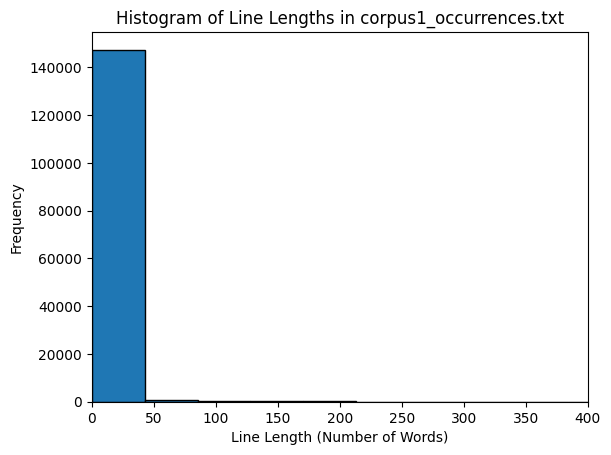

In [ ]:
import matplotlib.pyplot as plt

def get_line_lengths(file_path):
    line_lengths = []

    with open(file_path, 'r') as infile:
        for line in infile:
            words = line.strip().split()
            line_length = len(words)
            line_lengths.append(line_length)

    return line_lengths

if __name__ == "__main__":
    file_path = "corpus1_occurrences.txt"

    line_lengths = get_line_lengths(file_path)

    # Plot the histogram
    plt.hist(line_lengths, bins=100, edgecolor='black')
    plt.xlabel('Line Length (Number of Words)')
    plt.ylabel('Frequency')
    plt.title('Histogram of Line Lengths in corpus1_occurrences.txt')
    plt.xlim(0, 400)
    plt.show()
